## Задание 2

In [62]:
import os
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from mlflow.models import infer_signature
from sklearn.metrics import classification_report
from dotenv import load_dotenv


load_dotenv(dotenv_path='/home/alex-utk/Desktop/mlflow-docker-compose/.env') 
# load_dotenv() 
mlflow.set_tracking_uri(os.getenv('MLFLOW_TRACKING_URI')) 
mlflow.set_experiment("test-experiment123")
# так как целевая переменная у нас - вероятность заболевания, используем логистическую регрессию
# и будем решать задачу бинарной классификации

random_state = 42
data = pd.read_csv('/mnt/88fdd009-dda3-49d8-9888-cfd9d9d5910a/ITMO/STATS/FINISHED/3_diabetes_classification.csv')
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

В датасете необходимо предсказать, есть ли у человека диабет, или нет

* Pregnancies: Количество беременностей
* Glucose: Концентрация глюкозы в плазме через 2 часа после перорального теста на толерантность к глюкозе
* BloodPressure: Диастолическое артериальное давление (мм рт. ст.)
* SkinThickness: Толщина кожной складки на трицепсе (мм)
* Insulin: Уровень инсулина в сыворотке через 2 часа (мкЕд/мл)
* BMI: Индекс массы тела (вес в кг/(рост в м)^2)
* DiabetesPedigreeFunction: Функция наследственной предрасположенности к диабету
* Age: Возраст (лет)
* Outcome: Классовая переменная (0 или 1)

In [64]:
data.isna().sum() # пропусков нет, это хорошо

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [65]:
data['Outcome'].describe() # классы несбалансированы, диабет у 35% True и 65% False

count    768.000000
mean       0.348958
std        0.476951
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Outcome, dtype: float64

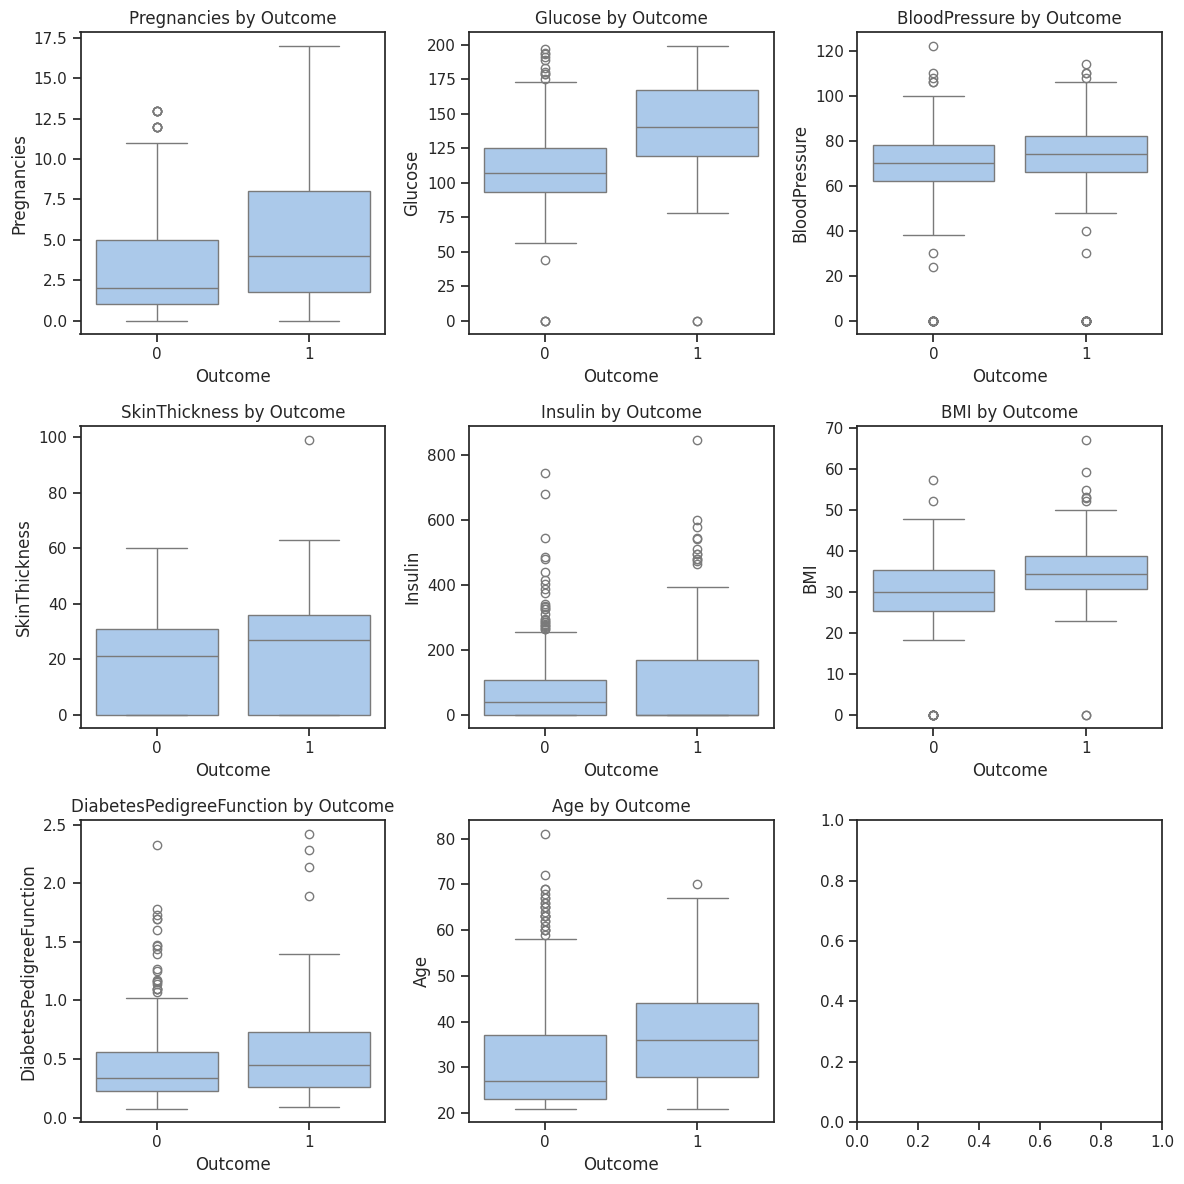

In [66]:
# посмотрим на зависимость таргета от фичей
target_name = 'Outcome'
feature_names = list(data.columns)
feature_names.remove(target_name)

plot_size = 4

plots_per_horisontal = 3
plots_per_vertical = np.ceil(len(feature_names) / plots_per_horisontal).astype(np.int8).item()

fig, axes = plt.subplots(plots_per_vertical, plots_per_horisontal,
                         figsize=(plot_size * plots_per_horisontal, plot_size * plots_per_vertical))
for idx, feature in enumerate(feature_names):
    i = idx // plots_per_horisontal
    j = idx % plots_per_horisontal
    sns.boxplot(data=data, x=target_name, y=feature, ax=axes[i,j])
    axes[i,j].set_title(f'{feature} by {target_name}')

plt.tight_layout()
plt.show()

Можем заметить определенную свять между заболеванием диабетом и колличеством беременностей, массой тела, наследственной предрасположенностью и возрастом.

Сильнее всего влияет возраст. А вот кожа почти не оказывает влияния (позднее это подтвердится при обучении)

In [33]:
# Попробуем добавить доп фичи
data['Glucose_Dynamics'] = 126 - 0.5 * data["Glucose"] * data['Insulin']
data['Insulin'] = data['Insulin'] / 23.3 - 67.1
data['BloodPressure^2'] = data['BloodPressure'] ** 2

bins = [
        (0, 18, 0),
        (18, 27, 1),
        (27, 45, 2),
        (45, 66, 3),
        (66, float("inf"), 4),
]
for lower, upper, label in bins:
    data.loc[(data['Age'] > lower) & (data['Age'] <= upper), "Age_bin"] = int(label)
data = data.drop(columns=['Age'])

data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness    Insulin   BMI  \
0            6      148             72             35 -67.100000  33.6   
1            1       85             66             29 -67.100000  26.6   
2            8      183             64              0 -67.100000  23.3   
3            1       89             66             23 -63.065665  28.1   
4            0      137             40             35 -59.889700  43.1   

   DiabetesPedigreeFunction  Outcome  Glucose_Dynamics  BloodPressure^2  \
0                     0.627        1             126.0             5184   
1                     0.351        0             126.0             4356   
2                     0.672        1             126.0             4096   
3                     0.167        0           -4057.0             4356   
4                     2.288        1          -11382.0             1600   

   Age_bin  
0      3.0  
1      2.0  
2      2.0  
3      1.0  
4      2.0

In [2]:
x = data.drop(columns=['Outcome', 'SkinThickness']) # выкинем SkinThickness, так как один из прогонов показал его неважность
y = data['Outcome']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=random_state,
    stratify=data['Outcome'] # стратифицируем по y, что бы в test и в train равные пропорции 0 и 1
) 


with mlflow.start_run() as active_run:
    run_id = active_run.info.run_id
    pipeline = Pipeline([
        ('scaler', StandardScaler()), # номализация фичей к mean=0, std=1
        ('classifier', LogisticRegression())
    ])

    param_grid = {
        'classifier__C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 40, 50, 100],
        'classifier__l1_ratio': np.linspace(0, 1, 20),
        'classifier__class_weight': ['balanced', None], # добавим балансировку
        'classifier__random_state': [random_state],
        'classifier__penalty': ['elasticnet'], # комбинация l1 (что бы дропать бесполезные признаки) и l2 (что бы не переобучиться)
        'classifier__solver': ['saga'],
        'classifier__n_jobs': [10],
    }

    # Найдем лучише параметры гридсерчем
    grid_search = GridSearchCV(pipeline,
                            param_grid,
                            cv=5,
                            scoring='f1',
                            n_jobs=10)

    # Fit the model
    grid_search.fit(x_train, y_train)

    # Print the best parameters and best score
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: ", grid_search.best_score_)
    
    predictions = grid_search.predict(x_train)
    signature = infer_signature(x_train, predictions)

    # Log parameter, metrics, and model to MLflow
    mlflow.log_param("grid_params", grid_search.best_params_)
    mlflow.log_param("best_f1_score", grid_search.best_score_)
    
    model_info = mlflow.sklearn.log_model(
        sk_model=grid_search,
        artifact_path="test-experiment123",
        signature=signature,
        registered_model_name="random",
    )

Best parameters found:  {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__l1_ratio': 0.5, 'classifier__n_jobs': 10, 'classifier__penalty': 'elasticnet', 'classifier__random_state': 42, 'classifier__solver': 'saga'}
Best cross-validation score:  0.6511199353991955


/mnt/88fdd009-dda3-49d8-9888-cfd9d9d5910a/ITMO/STATS/.venv/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'random'.
2024/10/16 00:58:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random, version

In [52]:
# precision отвечает за минимизацию ошибки 1 рода TP / (TP + FP)
# recall отвечает за минимизацию ошибки 2 рода  TP / (TP + FN)

# Общая точность 75%, но это не самый полезный показатель, так как у нас классы не сбалансированы
# Если мы указали, что человек болен диабетом, то мы угадали в 62% случаев
# Если мы указали, что человек НЕ болен диабетом, то мы угадали в 84% случаев
# Из общего количества больных диабетом мы поставили правильный диагноз в 74% случаев
# Из общего количества здоровых людей мы не стали их лечить в 75% случаев
model_name = "random"
model_version = "latest"

# Load the model from the Model Registry
model = mlflow.sklearn.load_model(f"models:/{model_name}/{model_version}")
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       100
           1       0.62      0.74      0.67        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.76      0.75      0.75       154



In [45]:
# Посмотрим на фичи, тут видно, что больше всего на вероятность диабета влияет уровень глюкозы (вес 1.073993) и индекс массы тела (0.707334).
# Во время первого прогона толщина кожи имеела самый низкий по модулю вес, что означает что это почти ни на что не влияет, поэтому от нее избавились.
# Модель довольно логично подобрала коэффициенты.

pd.DataFrame({
    'Признаки': x.columns.values.tolist(),
    'Веса': grid_search.best_estimator_['classifier'].coef_[0]
})

Признаки      Веса
0               Pregnancies  0.357673
1                   Glucose  1.073993
2             BloodPressure -0.160412
3                   Insulin -0.071249
4                       BMI  0.707334
5  DiabetesPedigreeFunction  0.290711
6                       Age  0.225578